In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import pickle
import torch
import io

In [4]:
# view counts and percentage for each column's elements
def view_column_counts(df, col_name):
    df_pivot = df.groupby(by = col_name).size().reset_index(name='Counts')
    df_pivot['Per (%)'] = (df_pivot['Counts'])/df.shape[0]*100
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    return df_pivot

In [5]:
# load original data and pre-processing
df = pd.read_csv('../data/cc_data.csv')

# remove unnecessary columns
col2remove = ['SIC Code', 'Return Amount', 'Reward Amount', 'Transaction ID', 
              'Account Identifier', 'Account Name', 'Account Number', 'Bank Name', 
              'Aggregator Name', 'Consumer ID', 'Consumer Created Date',
              'Transaction String', 'Posted Date', 'Data Creation Date', 
              'Consumer Postal Code', 'Consumer City Name','Ethnicity']
df.drop(col2remove, axis = 1, inplace = True, errors='ignore') 

# Only keep `purchase` rows for `Transaction Type`, and then remove `Trsansaction Type`
if 'Transaction Type' in df.columns:
    df = df[df['Transaction Type'] == 'purchase']
    df.drop('Transaction Type', axis = 1, inplace = True)
    
# calculate consumer age, any birth year after 2020 is converted to null, and then remove `Consumer Birth Year` column
if 'Consumer Birth Year' in df.columns:
    df['Age'] = df['Consumer Birth Year'].apply(lambda x: 2020 - int(x) if int(x) < 2020 else None)
    df.drop('Consumer Birth Year', axis = 1, inplace = True)
    
# convert `N\A` in `Transation date` into null
df['Transaction Date'].replace({"N\A":None}, inplace=True)
# convert `both` in `Consumer Gender` into null, only keep male and female
df['Consumer Gender'].replace({'both':None}, inplace=True)
# convert `investment_account` and `loans` in `Account Type` into null, only keep bank_account and credit_card
df['Account Type'].replace({'investment_account':None,'loans':None},inplace=True)
# remove missing values above
df.dropna(inplace = True)

# 'SIC Description' (114) - only keep top N and group the rest into `other`
N = 9
df_pivot = view_column_counts(df,'SIC Description')
list2keep = list(df_pivot.nlargest(N, 'Counts')['SIC Description'])
df['SIC Description'] = df['SIC Description'].apply(lambda x: x if x in list2keep else 'Other')
#df_pivot.head(N+1)

d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
list2keep

['Eating Places',
 'Grocery Stores',
 'Gasoline Service Stations',
 'Book Stores',
 'Drug Stores and Proprietary Stores',
 'Miscellaneous Food Stores',
 'Family Clothing Stores',
 'Taxicabs',
 'Communications Services, Not Elsewhere Classified']

In [7]:
df.head()
#df.to_csv('data/cc_data_processed.csv',index = False)

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Transaction Date,Age
0,credit_card,male,Red Robin,Eating Places,15.52,2019-07-01,22.0
1,bank_account,male,California Thai,Eating Places,11.29,2019-09-30,30.0
2,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,2019-06-24,34.0
3,bank_account,female,The Beer Store,Other,88.90,2018-10-01,43.0
4,bank_account,male,Intermarche,Grocery Stores,23.54,2019-12-01,62.0


In [8]:
#df_test = df.sample(n = 10000)
#sns.distplot(df_test['Age']);

d:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


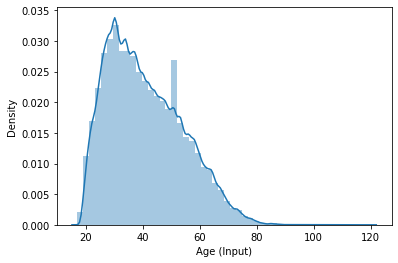

In [22]:
# ago histogram
ax = sns.distplot(df['Age']);
ax.set(xlabel='Age (Input)')
#plt.savefig('figs/eda/age_hist_input.png',bbox_inches='tight');

d:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


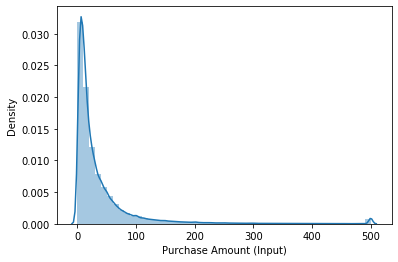

In [27]:
# check purchase amount, replace all values above the threshold to threshold
df["Purchase Amount Clipped"]= df["Purchase Amount"].clip(upper = 500) 
ax = sns.distplot(df['Purchase Amount Clipped']);
ax.set(xlabel='Purchase Amount (Input)')
#plt.savefig('figs/eda/purchase_hist_input.png',bbox_inches='tight')

In [28]:
# gender, account type, sector and retailer percentage
text_col_list = ['Account Type', 'Consumer Gender','Normalized Retailer', 'SIC Description']

for col_name in text_col_list:   
    print(col_name)
    df_pivot = view_column_counts(df,col_name)
    print(df_pivot)
    print('\n')

Account Type
   Account Type   Counts    Per (%)
0  bank_account  1878636  53.839509
1   credit_card  1610690  46.160491


Consumer Gender
  Consumer Gender   Counts    Per (%)
0          female  1949501  55.870417
1            male  1539825  44.129583


Normalized Retailer
         Normalized Retailer  Counts    Per (%)
2194             Tim Hortons  412788  11.830021
1361              McDonald's  212414   6.087537
2346                 Walmart  186174   5.335529
50                    Amazon  161985   4.642301
1930      Shoppers Drug Mart  106277   3.045774
...                      ...     ...        ...
1562  PITT MEADOWS GOLF CLUB       1   0.000029
2301          Village Bagels       1   0.000029
1561    PINEVIEW GOLF COURSE       1   0.000029
731                  Flipkey       1   0.000029
804   GRANITE SPRINGS GOLF C       1   0.000029

[2441 rows x 3 columns]


SIC Description
                                     SIC Description   Counts    Per (%)
3                                

In [29]:
# view purchase amounts for each column's elements
def view_column_purchase(df, col_name):
    df_pivot = df.groupby(by = col_name)['Purchase Amount'].apply(list).reset_index(name = 'Purchase List')
    df_pivot['Counts'] = df_pivot['Purchase List'].apply(len)
    df_pivot.sort_values(by = 'Counts',ascending = False,inplace = True)
    df_pivot = df_pivot.reset_index(drop=True)
    return df_pivot

# df_sector = view_column_purchase(df, 'SIC Description')
# print("Top sectors: ", list(df_sector.nlargest(5, 'Counts')['SIC Description']))
# df_sector.head()

barplot for SIC Description


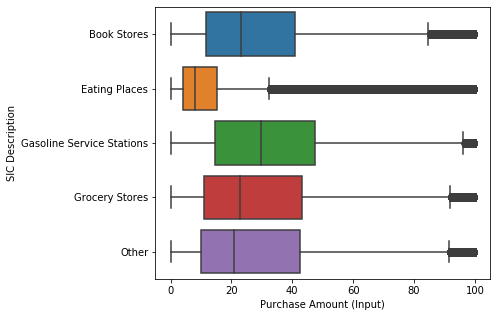

barplot for Normalized Retailer


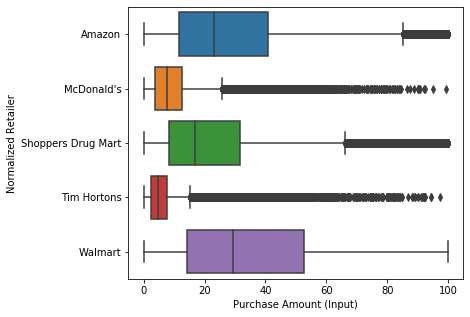

In [36]:
check_list = ['SIC Description','Normalized Retailer']
fig_dims = [6, 5] 
N = 5
threshold = 100

for cat in check_list:   
    print("barplot for %s" % (cat))
    list_tmp = df[cat].value_counts()[:N].index.tolist() # top N counts in that category
    df_tmp = df[df[cat].isin(list_tmp) & (df['Purchase Amount'] < threshold)].sort_values(by = cat)
    fig, ax = plt.subplots(figsize = fig_dims)
    chart = sns.boxplot(y = df_tmp[cat], x = df_tmp['Purchase Amount'])
    ax.set(xlabel='Purchase Amount (Input)')
    #plt.savefig('figs/eda/purchase_' + cat + '_input.png',bbox_inches='tight')
    plt.show()
